In [1]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

In [2]:
#import ast
#import matplotlib
#import matplotlib.pyplot as plt

#f = open("hamiltonians.txt","r")
#hamiltonians = ast.literal_eval(f.read())
#f.close()

#for h in hamiltonians.keys():
#    print(h, '# qubits:', hamiltonians[h][1], 'A terms:', hamiltonians[h][5][3][1])

In [3]:
#speciesname = 'H1-He1_STO-3G_singlet'

#encoding = hamiltonians[speciesname][0] # in this dataset, always 'JW' for Jordan-Wigner, but leaves room for trying Bravyi-Kitaev as well
#num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
#ham = hamiltonians[speciesname][2] # full Hamiltonian
#ham_noncon = hamiltonians[speciesname][3] # noncontextual part of Hamiltonian, found by greedy DFS
#true_gs = hamiltonians[speciesname][4] # ground state energy of full Hamiltonian (in Hartree)
#gs_noncon = hamiltonians[speciesname][5] # list containing information about noncontextual ground state: zeroth entry is ground state energy of noncontextual part of Hamiltonian
#print('commuting generators:',model[0], '\n')
#print('anticommuting generators:',model[1], '\n')
#print('term reconstruction:',model[2], '\n')

#print('number of qubits:', num_qubits)
#print('true ground state energy:', true_gs)
#print('noncontextual approximation to ground state energy:', gs_noncon[0])
#print(ham_noncon)

In [4]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069372+0j) [] +
(-0.025810254414802718+0j) [X0 X1 Y2 Y3] +
(-0.012799934786441543+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839892424+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786441543+0j) [X0 X1 X3 X4] +
(-0.02515964583989242+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.01711452882177704+0j) [X0 X1 Y4 Y5] +
(-0.000989104910370992+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.000989104910370992+0j) [X0 X1 X5 X6] +
(-0.05469856574685571+0j) [X0 X1 Y6 Y7] +
(0.025810254414802718+0j) [X0 Y1 Y2 X3] +
(0.012799934786441543+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839892424+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786441543+0j) [X0 Y1 Y3 X4] +
(-0.02515964583989242+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.01711452882177704+0j) [X0 Y1 Y4 X5] +
(0.000989104910370992+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.000989104910370992+0j) [X0 Y1 Y5 X6] +
(0.05469856574685571+0j) [X0 Y1 Y6 X7] +
(0.002577905179377272+0j) [X0 Z1 X2] +
(0.004766148105679894+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923300441+0j) [X0 Z1 X2 X3 Z4 Z5 Z

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [5]:
ham = q_conv.QubitOperator_to_dict(ham_q, num_qubits)
anz_terms = list((q_conv.QubitOperator_to_dict(ucc_q, num_qubits)).keys())
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
#ham_noncon
terms_context = list(ham.keys() - terms_noncon)
ham_context = {t:ham[t] for t in terms_context}
#ham_context
c.contextualQ_ham(ham_context)

True

In [6]:
from qiskit.aqua.algorithms import NumPyEigensolver

result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham)).run()
true_gs = np.real(result.eigenvalues)

print(true_gs)

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


[-3.16676548]


/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


In [7]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}
c.csvqe_approximations_heuristic(ham, ham_noncon, num_qubits, true_gs)
#c.contextualQ_ham(ham_context)

[array([-3.16676548]),
 [-3.1428247492681685,
  -3.1518728818629755,
  -3.1518728818629778,
  -3.155710388287116,
  -3.159114851913749,
  -3.1591148519137544,
  -3.161949005650515,
  -3.166765477254412,
  -3.166765477254408],
 [array([0.02394073]),
  array([0.0148926]),
  array([0.0148926]),
  array([0.01105509]),
  array([0.00765063]),
  array([0.00765063]),
  array([0.00481647]),
  array([3.99680289e-15]),
  array([7.99360578e-15])],
 [6, 2, 0, 4, 1, 3, 5, 7]]

In [8]:
model[0:2], gs_noncon_energy, ep_state

((['ZIIIIIZI',
   'IZIIIIIZ',
   'IIZIIIII',
   'IIIZIIII',
   'IIIIZIII',
   'IIIIIZII',
   'IIIIIIIZ'],
  ['YZZZZZYZ', 'IIIIIIZI']),
 -3.1428247492681693,
 [[-1, -1, 1, -1, 1, 1, 1], [0.04017214145130927, 0.9991927737184733]])

In [26]:
new_model = c.quasi_model(new_rot_ham_noncon)
new_fn_form = c.energy_function_form(new_rot_ham_noncon, new_model)
new_gs_noncon = c.find_gs_noncon(new_rot_ham_noncon)
new_gs_noncon_energy = new_gs_noncon[0]
new_ep_state = new_gs_noncon[1]

new_model[0:2], new_gs_noncon_energy, new_ep_state

((['ZIIIIIZI', 'IZIIZIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII'],
  ['YIZZZZYI', 'IIIIIIZI']),
 -2.090320174450916,
 [[-1, -1, 1, -1, 1, 1], [-0.14844358230034105, 0.9889208779643809]])

# The epistemic state defines a classical probability distribution:

In [9]:
def ontic_prob(ep_state, ontic_state):
    
    if ep_state[0] != ontic_state[0]:
        return 0
    
    else:
        prod = 1
        for index, r in enumerate(ep_state[1]):
            f = 1/2 * abs(r + ontic_state[1][index])
            prod *= f
        
        return prod    

def epistemic_dist(ep_state):
    size_G = len(ep_state[0])
    size_Ci = len(ep_state[1])
    size_R = size_G + size_Ci
    
    ep_prob = {}
    
    ontic_states = list(itertools.product([1, -1], repeat=size_R))
    
    for o in ontic_states:
        o_state = [list(o[0:size_G]), list(o[size_G:size_R])]
        o_prob = ontic_prob(ep_state, o_state)
        
        if o_prob != 0:
            ep_prob[o] = o_prob
    
    return ep_prob

In [10]:
epistemic_dist(ep_state)

{(-1, -1, 1, -1, 1, 1, 1, 1, 1): 0.5198761571531817,
 (-1, -1, 1, -1, 1, 1, 1, 1, -1): 0.00020991357247286178,
 (-1, -1, 1, -1, 1, 1, 1, -1, 1): 0.4797202297060548,
 (-1, -1, 1, -1, 1, 1, 1, -1, -1): 0.00019369956829050849}

# Find a simultaneous eigenstate of the operators G_i and A:

In [11]:
from copy import deepcopy

G = model[0]
fixed_qubits = ['I' for i in range(num_qubits)]
basis_ops = []
mult_Z_indices = []

for index, g in enumerate(G):
    Z_indices = [i for i, p in enumerate(list(g)) if p == 'Z']
    if len(Z_indices) == 1:
        if ep_state[0][index] == -1:
            fixed_qubits[Z_indices[0]] = 1
        else:
            fixed_qubits[Z_indices[0]] = 0
    else:
        mult_Z_indices.append([ep_state[0][index], Z_indices])
        
print(fixed_qubits)

for Z_indices in mult_Z_indices:
    Z0, Z1 = Z_indices[1][0], Z_indices[1][1] 
    q0, q1 = fixed_qubits[Z0], fixed_qubits[Z1]
    
    if q0 != q1:
        if q0 != 'I':
            if Z_indices[0] == -1:
                fixed_qubits[Z1] = (q0+1)%2
            else:
                fixed_qubits[Z1] = q0
        else:
            if Z_indices[0] == -1:
                fixed_qubits[Z0] = (q1+1)%2
            else:
                fixed_qubits[Z0] = q1
        mult_Z_indices.remove(Z_indices)
            
for Z_indices in mult_Z_indices:
    if Z_indices[0] == -1:
        fixed = deepcopy(fixed_qubits)
        fixed[Z_indices[1][0]] = 0
        fixed[Z_indices[1][1]] = 1
        fixed = [str(i) for i in fixed]
        basis_ops.append(''.join(fixed))
        
        fixed = deepcopy(fixed_qubits)
        fixed[Z_indices[1][0]] = 1
        fixed[Z_indices[1][1]] = 0
        fixed = [str(i) for i in fixed]
        basis_ops.append(''.join(fixed))
    
print(basis_ops)

['I', 'I', 0, 1, 0, 0, 'I', 0]
['01010010', '11010000']


# Construct +1-Eigenstates of A(r)

In [12]:
r1 = ep_state[1][0]
r2 = ep_state[1][1]
#t = np.arctan((r2 + 1) / r1)
r1, r2

(0.04017214145130927, 0.9991927737184733)

In [105]:
import itertools
from itertools import chain, combinations
from copy import deepcopy

def bin_to_int(bits):
    bit_string = deepcopy(bits)
    
    if type(bit_string) == str:
        bit_string = [int(b) for b in bit_string]
        
    for index, b in enumerate(bit_string):
        bit_string[index] = b * 2 ** (len(bit_string)-index-1)
    
    return sum(bit_string)


def add_eigenstate(r1, r2, index, theta, n, num_qubits, custom_amp=None):
    """
    """
    B = list(itertools.product([0,1], repeat=num_qubits))
    b1 = list(B[index])
    b2 = deepcopy(b1)
    b2[0] = (b2[0]+1)%2
    b2[6] = (b2[6]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)

    parity=sum(b1)
    q1 = b1[6]
    
    amp_ratio = (1 + r2 * (-1)**q1) / (r1 * (-1)**(1 + parity))
    t = ((-1)**n)*np.arctan(amp_ratio)
    psi = [0 for i in range(2**num_qubits)]
    
    if custom_amp is None:   
        psi[i1] = np.sin(t)*np.exp(1j*theta)
        psi[i2] = np.cos(t)*np.exp(1j*(theta - n*np.pi))
    else:
        psi[i1] = custom_amp[0]
        psi[i2] = custom_amp[1]
        
    return np.array(psi)


def expectation(op, state):
    state = np.array(state)
    conj_state = np.conjugate(state)
    O = LinearQubitOperator(op, num_qubits)
    
    O_state = O.matvec(state)
    expect = conj_state.dot(O_state)
    
    return expect


def discard_generator(ham_noncon, ham_context, generators):
    new_ham_noncon = deepcopy(ham_noncon)
    new_ham_context = deepcopy(ham_context)
    
    Z_indices = [g.index('Z') for g in generators]
    removed=[]
    
    for index in Z_indices:
        for p in ham_noncon:
            if p not in removed:
                if p[index] == 'Z':
                    new_ham_context[p] = ham_noncon[p]
                    del new_ham_noncon[p]
                    removed.append(p)
            
    return new_ham_noncon, new_ham_context


def rotate_hamiltonian(rotations, ham, ham_noncon, ham_context):
    
    rot_ham={}
    rot_ham_noncon={}
    rot_ham_context={}

    for p in ham.keys():
        p_ref = deepcopy(p)
        parity = 1
        coeff = ham[p]
        for r in rotations:
            rotate_p = c.apply_rotation(r, p)
            p = list(rotate_p.keys())[0]
            parity *= rotate_p[p]
        
        rot_ham[p] = parity * coeff
        if p_ref in ham_noncon.keys():
            rot_ham_noncon[p] = parity * coeff
        else:
            rot_ham_context[p] = parity * coeff
            
    return rot_ham, rot_ham_noncon, rot_ham_context


def rotate_state(rotations, state):
    
    rot_state = deepcopy(state)
    
    for r in rotations:
        r_op = QubitOperator('', 1/np.sqrt(2)) - q_conv.dict_to_QubitOperator({r[1]: 1/np.sqrt(2)*1j}, num_qubits)
        r_op = LinearQubitOperator(r_op, num_qubits)
        rot_state = r_op.matvec(rot_state)
        
    return rot_state


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def find_eigenstate_indices(initial, removed_Z_indices):
    bins = []
    index_powerset = list(powerset(removed_Z_indices))
    
    for comb in index_powerset:
        initial_ref = list(deepcopy(initial))
        for c in comb:
            initial_ref[c] = str((int(initial_ref[c])+1)%2)
        bins.append(bin_to_int(''.join(initial_ref)))
    
    return bins

In [14]:
from openfermion.linalg import LinearQubitOperator

ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = q_conv.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = q_conv.dict_to_QubitOperator(ham_context, num_qubits)

#take expectation value algebraically

for p in np.linspace(0, 1, 1):
    psi = add_eigenstate(r1=r1, r2=r2, index=82, theta=0, n=0, num_qubits=num_qubits)
    expect = expectation(ham_q, psi)
    
    print('<H> w.r.t. simultaneous eigenstate:', expect)
    print('Noncontextual approximation:', gs_noncon_energy)
    print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-3.1428247492681685+0j)
Noncontextual approximation: -3.1428247492681693
Expectation values match? True


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


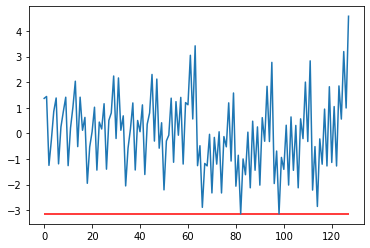

In [15]:
from matplotlib import pyplot as plt

X=[]
Y=[]

for i in range(2**(num_qubits-1)):
    X.append(i)
    psi = add_eigenstate(r1=r1, r2=r2, index=i, theta=0, n=0, num_qubits=num_qubits)

    Y.append(expectation(ham_noncon_q, psi))

plt.plot(X, Y)
plt.hlines(gs_noncon_energy, 0, 127, color='r')
plt.show()

In [16]:
import math

def random_vector(n):
    components = [np.random.normal() for i in range(n)]
    r = math.sqrt(sum(x*x for x in components))
    v = [x/r for x in components]
    return v

/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


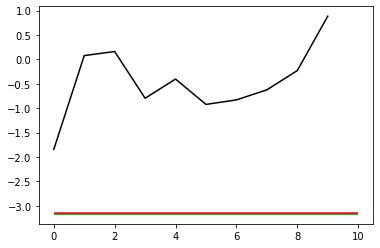

In [135]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10

#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
new_rot_ham_noncon, new_rot_ham_context = discard_generator(ham_noncon, ham_context, ['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII'])

rot_ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
new_rot_ham_noncon_q = q_conv.dict_to_QubitOperator(new_rot_ham_noncon, num_qubits)
new_rot_ham_context_q = q_conv.dict_to_QubitOperator(new_rot_ham_context, num_qubits)


def expectation_optimiser(ham_noncon_q, ham_context_q, p):
    eigenstate_indices = find_eigenstate_indices('01010010', [7, 5, 4, 3, 2])
    
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(eigenstate_indices):
        psi += (p[index])*add_eigenstate(r1=r1, r2=r2, theta=0, n=0, index=i, num_qubits=num_qubits)
    
    expect_noncon = expectation(ham_noncon_q, psi)
    expect_context = expectation(ham_context_q, psi)
    
    return expect_noncon + expect_context

eigenstate_indices = find_eigenstate_indices('01010010', [7, 5, 4, 3, 2])
X=[random_vector(len(eigenstate_indices)) for i in range(shots)]
Y_noncon=[]
Y_context=[]
Y_combined=[]
Y_full=[]

#A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
#A = LinearQubitOperator(A_op, num_qubits)

for p in X:
    expect = expectation_optimiser(new_rot_ham_noncon_q, new_rot_ham_context_q, p)

    #Y_full.append(expect_full)
    #Y_noncon.append(expect_noncon)
    #Y_context.append(expect_context)
    Y_combined.append(expect)
    
    #print(p, expect_noncon + expect_context < gs_noncon_energy)
    #print((np.conjugate(psi)).dot(psi))
    #Verify +1-eigenstate
    #A_psi = A.matvec(psi)
    #print(psi_conj.dot(A_psi))

#plt.plot(range(shots), Y_noncon, color='orange')
#plt.plot(range(shots), Y_context, color='blue')
plt.plot(range(shots), Y_combined, color='black')
#plt.plot(range(shots), Y_combined, color='purple')
plt.hlines(gs_noncon_energy, 0, shots, color='r')
plt.hlines(true_gs, 0, shots, color='g')
#print('<H> w.r.t. simultaneous eigenstate:', expect)
#print('Noncontextual approximation:', gs_noncon_energy)
#print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [131]:
import numpy as np
from scipy.optimize import minimize

def opt(p):
    return expectation_optimiser(new_rot_ham_noncon_q, new_rot_ham_context_q, p)

p0 = np.array(random_vector(len(eigenstate_indices)))

res = minimize(opt, p0, method='BFGS', jac=rosen_der,
               options={'disp': True})

NameError: name 'rosen_der' is not defined

# Do we have any quantum corrections?

In [263]:
G = model[0]
terms_context = list(ham_context.keys())
G

['ZIIIIIZI',
 'IZIIIIIZ',
 'IIZIIIII',
 'IIIZIIII',
 'IIIIZIII',
 'IIIIIZII',
 'IIIIIIIZ']

In [264]:
q_corr_terms = []
for t in terms_context:
    commutes = []
    for g in G:
        if c.commute(t, g):
            commutes.append(g)
    #print(t, 'commutes with the noncontextual generators:', commutes)
    if commutes == G:
        q_corr_terms.append(t)
        
if q_corr_terms == []:
    print('No quantum correction')
else:
    print('Terms admitting quantum correction:', q_corr_terms)

No quantum correction


In [265]:
#psi2 = [0 for i in range(2**num_qubits)]
#psi2[bin_to_int('000011')] = np.sin(t)
#psi2[bin_to_int('010111')] = -np.cos(t)

In [266]:
#from qiskit import QuantumCircuit
#from qiskit.extensions import Initialize
#from qiskit.circuit import Parameter

#anz = QuantumCircuit(num_qubits) # We are redefining qc
#anz.initialize(psi)
#anz.ry(Parameter('x'), 3)
#anz.initialize(psi2)
#anz.rx(Parameter('y'), 3)

In [267]:
#from qiskit.utils import QuantumInstance, algorithm_globals
#from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
#from qiskit.algorithms import VQE
#from qiskit.quantum_info.operators.symplectic.pauli import Pauli
#from qiskit.opflow.primitive_ops import PauliOp
#from qiskit import Aer

#ham_qiskit = sum([PauliOp(Pauli(k), ham[k]) for k in ham.keys()])

#seed = 50
#algorithm_globals.random_seed = seed
#qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
#slsqp = SLSQP(maxiter=1000)

#vqe = VQE(anz, optimizer=slsqp, quantum_instance=qi)
#vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham_qiskit)
#vqe_result = vqe_run.optimal_value# + shift

#print('VQE:', vqe_result, '|', 'Noncontextual Ground State:', gs_noncon_energy, 'True Ground State:', true_gs)

In [268]:
from qiskit.aqua.algorithms import NumPyEigensolver

order = [0,1,2,3,4,5,6,7]
print(c.contextual_subspace_approximations(ham,model,fn_form,ep_state,order))

result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham)).run()
exact_energy = np.real(result.eigenvalues)

print(exact_energy)

[-3.14282474926818, -3.14282474926818, -3.142824749268179, -3.143939975054505, -3.1459507148542003, -3.148913349475541, -3.154301104750847, -3.1667654772544287, -3.166765477254425]
[-3.16676548]


In [269]:
rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]
#rotations.reverse()
rotations

[['pi/2', 'YIIIIIII'],
 ['pi/2', 'YIIIIIZI'],
 ['pi/2', 'IYIIIIII'],
 ['pi/2', 'IYIIIIIZ']]

In [25]:
rot_G=[]

for g in G:
    for r in rotations:
        rotate_g = c.apply_rotation(r, g)
        g = list(rotate_g.keys())[0]
    rot_G.append(g)
    
rot_G

['ZIIIIIII',
 'IZIIIIII',
 'IIZIIIII',
 'IIIZIIII',
 'IIIIZIII',
 'IIIIIZII',
 'IIIIIIIZ']

In [215]:
from copy import deepcopy

psi = add_eigenstate(r1=r1, r2=r2, index=82, theta=0, n=0, num_qubits=num_qubits)


    


rotate_state(rotations, psi)


array([ 0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.99979817+0.j,  0.        +0.j, -0.02009013+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  

In [209]:
from openfermion.linalg import LinearQubitOperator

rot_psi = np.array(rot_psi)
rot_psi_conj = np.conjugate(rot_psi)


#rot_ham = c.get_reduced_hamiltonians(ham,model,fn_form,ep_state,order=[0,1,2,3,4,5,6,7])[8]

rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)

rot_ham_q = q_conv.dict_to_QubitOperator(rot_ham_noncon, num_qubits)

#take expectation value algebraically
rot_H = LinearQubitOperator(rot_ham_q, num_qubits)
rot_H_psi = rot_H.matvec(rot_psi)
rot_expect = rot_psi_conj.dot(rot_H_psi)

print('<H> w.r.t. rotated simultaneous eigenstate:', rot_expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(rot_expect - gs_noncon_energy) < 10**-14) #sanity check - expectation values match? 

<H> w.r.t. rotated simultaneous eigenstate: (-3.142824749268176+0j)
Noncontextual approximation: -3.142824749268179
Expectation values match? True


{'IIIIIIII': (1.1324434021069387+0j),
 'ZIIIIIZI': (-0.1399063176082593+0j),
 'IIZIIIII': (-0.2460736852001976+0j),
 'IIIZIIII': (-0.24607368520019762+0j),
 'IIIIZIII': (-0.6730850144698568+0j),
 'IIIIIZII': (-0.6730850144698568+0j),
 'IIIIIIZI': (-1.140216532490733+0j),
 'IIZZZZXI': (-0.06584241123629504+0j),
 'ZIZZZZXI': (-0.06584241123629504+0j),
 'ZIZIIIZI': (-0.11107234328900764+0j),
 'ZIIZIIZI': (-0.13688259770382208+0j),
 'ZIIIZIZI': (-0.12602660899459167+0j),
 'ZIIIIZZI': (-0.14314113781636645+0j),
 'ZIIIIIII': (-0.17642194958972313+0j),
 'IZZZZZXI': (0.07064370485657431+0j),
 'ZZZZZZXI': (0.07064370485657431+0j),
 'IZIIIIII': (-0.17642194958972313+0j),
 'IIZZIIII': (0.13657384315761087+0j),
 'IIZIZIII': (0.11407664418119323+0j),
 'IIZIIZII': (0.14063916899332368+0j),
 'IIZIIIZI': (0.10734715467055655+0j),
 'IIIZZIII': (0.14063916899332368+0j),
 'IIIZIZII': (0.11407664418119323+0j),
 'IIIZIIZI': (0.12260512697395277+0j),
 'IIIIZZII': (0.17095384888864143+0j),
 'IIIIZIZI': (0.11

In [100]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10

H = LinearQubitOperator(ham_noncon_q, num_qubits)
X=[random_vector(2) for i in range(shots)]
indices = [82, 19]
Y=[]

#A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
#A = LinearQubitOperator(A_op, num_qubits)

for p in X:
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(indices):
        psi += (p[index])*add_eigenstate(r1=r1, r2=r2, theta=0, n=0, index=i, num_qubits=num_qubits)
    psi_conj = np.conjugate(psi)

    rot_H_psi = rot_H.matvec(rot_psi)
    expect = psi_conj.dot(H_psi)
    Y.append(expect)
    
    #Verify +1-eigenstate
    A_psi = A.matvec(psi)
    #print(psi_conj.dot(A_psi))

plt.plot(range(shots), Y)
plt.hlines(gs_noncon_energy, 0, 10, color='r')
#print('<H> w.r.t. simultaneous eigenstate:', expect)
#print('Noncontextual approximation:', gs_noncon_energy)
#print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

True

In [78]:
rot_psi.dot(rot_H.matvec(rot_psi)), psi.dot(H.matvec(psi))

((-3.142824749268176+0j), (-3.14282474926818+0j))

In [44]:
get_ground_state(get_sparse_operator(rot_ham_q, num_qubits).toarray())

NameError: name 'get_ground_state' is not defined

In [52]:
rot_G[6], ham_noncon

('IIIIIIIZ',
 {'IIIIIIZI': (-1.140216532490733+0j),
  'IIIIIIIZ': (-1.1402165324907327+0j),
  'IIIIIIII': (1.1324434021069387+0j),
  'IIIIZIII': (-0.6730850144698568+0j),
  'IIIIIZII': (-0.6730850144698568+0j),
  'ZZIIIIII': (0.249918387936909+0j),
  'IIIZIIII': (-0.24607368520019762+0j),
  'IIZIIIII': (-0.2460736852001976+0j),
  'IIIIIIZZ': (0.23196260932848578+0j),
  'ZIIIIIIZ': (0.23112051533657274+0j),
  'IZIIIIZI': (0.23112051533657274+0j),
  'ZIIIIIZI': (0.17642194958972313+0j),
  'IZIIIIIZ': (0.17642194958972313+0j),
  'IIIIZZII': (0.17095384888864143+0j),
  'ZIIIIZII': (0.14314113781636645+0j),
  'IZIIZIII': (0.14314113781636645+0j),
  'IIZIIZII': (0.14063916899332368+0j),
  'IIIZZIII': (0.14063916899332368+0j),
  'ZIIIIIII': (0.1399063176082593+0j),
  'IZIIIIII': (0.13990631760825928+0j),
  'ZIIZIIII': (0.13688259770382208+0j),
  'IZZIIIII': (0.13688259770382208+0j),
  'IIZZIIII': (0.13657384315761087+0j),
  'ZIIIZIII': (0.12602660899459167+0j),
  'IZIIIZII': (0.12602660899459

In [ ]:
def bin_to_int(bits):
    if type(bits) == str:
        bits = [int(b) for b in bits]
    for index, b in enumerate(bits):
        bits[index] = b * 2 ** (len(bits)-index-1)
    return sum(bits)

In [ ]:
from copy import deepcopy

v1 = [0,0,0,0,1,1,1,1]
v2 = deepcopy(v1)
v2[0] = (v2[0]+1)%2
v2[6] = (v2[6]+1)%2

In [ ]:
bin_to_int(v1), bin_to_int(v2)

In [ ]:
import itertools
from matplotlib import pyplot as plt

B = list(itertools.product([0,1], repeat=8))

X=[]
Y=[]

for b1 in B[0:128]:
    b1 = list(b1)
    b2 = deepcopy(b1)
    b2[0] = (b2[0]+1)%2
    b2[6] = (b2[6]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    X.append(i1)
    Y.append(i2)
    print(i1, i2, i2-i1)
    
plt.scatter(X, Y, s=3)

In [ ]:
np.exp(0.6*1j)

In [44]:
bin_to_int('01011010')

90

In [243]:
from openfermion.linalg import get_sparse_operator, get_ground_state, generate_linear_qubit_operator

sparse_ham_q = get_ground_state(get_sparse_operator(ham_noncon_q, num_qubits).toarray())
sparse_ham_q

(-3.142824749268173,
 array([ 1.37853761e-17-1.33832817e-17j, -1.22049888e-18-4.81352046e-18j,
         8.45315419e-18+4.84771373e-18j, -7.18006173e-18+2.27654512e-18j,
        -2.42738100e-17+9.15729735e-18j,  1.24272315e-17-9.17423256e-18j,
        -1.85363597e-18+8.40111083e-18j, -2.47633257e-17+2.51438650e-17j,
         1.25605255e-17+4.39165369e-17j,  2.15517847e-18-1.21592665e-17j,
        -1.32232039e-18-1.03215746e-17j, -6.83978915e-18-9.85398234e-18j,
        -1.79315232e-18-1.93927738e-17j, -2.06565097e-17+1.41043086e-17j,
         1.45265706e-17-1.03092762e-17j,  5.58826039e-18-9.63121827e-19j,
         3.14503694e-18-1.11282339e-18j,  1.21595805e-17+9.72910383e-18j,
         9.35197322e-18+2.80658016e-18j, -2.27423720e-18-1.22590709e-17j,
         4.46911997e-20-1.20475896e-19j,  1.94332092e-17+9.33972304e-19j,
         5.35778353e-18+8.31916212e-18j, -1.62180622e-17+1.64989253e-17j,
        -3.48354834e-19-1.42083864e-17j, -2.84263830e-19-9.99230390e-19j,
         3.979285

In [113]:
add_eigenstate(r1=r1, r2=r2, index=19, theta=0, n=0, num_qubits=num_qubits)[145]

(0.9997981730624983+0j)

In [179]:
discard_generator(ham_noncon, ham_context, ['IIIIIIIZ', 'IIIIIZII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII'])[0]

{'IIIIIIZI': (-1.140216532490733+0j),
 'IIIIIIII': (1.1324434021069387+0j),
 'ZIIIIIZI': (0.17642194958972313+0j),
 'ZIIIIIII': (0.1399063176082593+0j)}

In [62]:
eigenstate_indices = [82, 83, 86, 87, 90, 91, 94, 95]

In [72]:
initial = 82
indices = []
removed_Z_indices = [7, 5, 4]
for i in removed_Z_indices:
    indices.append(initial)
    indices.append(initial+1)
    
    initial += 2**i

indices





[82, 83, 86, 87, 94, 95]